#  **sequential + functional API _ MNIST**



In [ ]:
from __future__ import print_function, division

from keras.datasets import mnist

from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam

import matplotlib.pyplot as plt
import sys
import numpy as np

In [ ]:
class GAN():
    def __init__(self):
        self.img_rows = 28
        self.img_cols = 28
        self.channels = 1
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = 100

        optimizer = Adam(0.0002, 0.5)
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy'])

        self.generator = self.build_generator()
        z = Input(shape=(self.latent_dim,))
        img = self.generator(z)
        self.discriminator.trainable = False
        validity = self.discriminator(img)
        self.combined = Model(z, validity)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)

    def build_generator(self):

        model = Sequential()

        model.add(Dense(256, input_dim=self.latent_dim))
        # マイナスで勾配が消失する問題（dying ReLU）を防ぐためのReLU
        model.add(LeakyReLU(alpha=0.2))
        # ノイズから生成してるから逐一、正規化してる？
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(1024))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        # np.prod(a) 配列aの全要素の積 →  img_shapeに変形できるようにしている
        model.add(Dense(np.prod(self.img_shape), activation='tanh'))
        # 最後に写真の次元に変形して出力
        model.add(Reshape(self.img_shape))

        model.summary()

        noise = Input(shape=(self.latent_dim,))
        img = model(noise)
        return Model(noise, img)

    def build_discriminator(self):
        model = Sequential()

        # 最終的に出力を１次元にするため、Flatten で１次元配列に変換
        model.add(Flatten(input_shape=self.img_shape))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(256))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(1, activation='sigmoid'))
        model.summary()

        img = Input(shape=self.img_shape)
        validity = model(img)

        return Model(img, validity)
    
    def train(self, epochs, batch_size=128, sample_interval=50):
        (X_train, _), (_, _) = mnist.load_data()
        X_train = X_train / 127.5 - 1.
        X_train = np.expand_dims(X_train, axis=3)

        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        for epoch in range(epochs):
            # バッチサイズと同じ数のインデックスをランダムに取得
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs = X_train[idx]

            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
            gen_imgs = self.generator.predict(noise)

            # 単一バッチデータにつき勾配更新を行う。
            d_loss_real = self.discriminator.train_on_batch(imgs, valid)
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
            g_loss = self.combined.train_on_batch(noise, valid)

            # D は、評価関数(metrics）を持つので返り値がリスト
            if epoch%100==0:
                print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

if __name__ == '__main__':
    gan = GAN()
    gan.train(epochs=5000, batch_size=32, sample_interval=200)

#  **subclass _ CIFAR-10**



In [ ]:
from __future__ import print_function, division

#from keras.datasets import mnist
from keras.datasets import cifar10

from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam

import tensorflow as tf

import matplotlib.pyplot as plt
import sys
import numpy as np

In [ ]:
class Discriminator(Model):
    def __init__(self):
      img_rows = 32
      img_cols = 32
      channels = 3
      img_shape = (img_rows, img_cols, channels)
      self.latent_dim = 100
    
      super(Discriminator, self).__init__()
      self.flatten = Flatten(input_shape=img_shape)
      self.d1 = Dense(512)
      self.lrelu1 = LeakyReLU(alpha=0.2)
      self.d2 = Dense(256)
      self.lrelu2 = LeakyReLU(alpha=0.2)
      self.d3 = Dense(1, activation='sigmoid')

    def call(self, x):
      x = self.flatten(x)
      x = self.d1(x)
      x = self.lrelu1(x)
      x = self.d2(x)
      x = self.lrelu2(x)
      valid = self.d3(x)
      return valid

In [ ]:
class Generator(Model):
    def __init__(self):
      img_rows = 32
      img_cols = 32
      channels = 3
      img_shape = (img_rows, img_cols, channels)
      self.latent_dim = 100

      super(Generator, self).__init__()
      self.d1 = Dense(256)
      self.lrelu1 = LeakyReLU(alpha=0.2)
      self.bn1 = BatchNormalization(momentum=0.8)
      self.d2 = Dense(512)
      self.lrelu2 = LeakyReLU(alpha=0.2)
      self.bn2 = BatchNormalization(momentum=0.8)
      self.d3 = Dense(1024)
      self.lrelu3 = LeakyReLU(alpha=0.2)
      self.bn3 = BatchNormalization(momentum=0.8)
      self.d4 = Dense(np.prod(img_shape), activation='tanh')
      self.reshape = Reshape(img_shape)

    def call(self, x):
      x = self.d1(x)
      x = self.lrelu1(x)
      x = self.bn1(x)
      x = self.d2(x)
      x = self.lrelu2(x)
      x = self.bn2(x)
      x = self.d3(x)
      x = self.lrelu3(x)
      x = self.bn3(x)
      x = self.d4(x)
      img = self.reshape(x)
      return img

In [ ]:
class GAN():
    def __init__(self):
        self.latent_dim = 100

        self.loss_object = tf.keras.losses.BinaryCrossentropy()
        self.optimizer = tf.keras.optimizers.Adam(0.0002, 0.5)

        self.d_loss = tf.keras.losses.BinaryCrossentropy(name='d_train_loss')
        self.d_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='d_accuracy')
        self.g_loss = tf.keras.losses.BinaryCrossentropy(name='g_train_loss')
        self.optimizer = Adam(0.0002, 0.5)

        self.discriminator = Discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
            optimizer=self.optimizer,
            metrics=['accuracy'])
        
        self.generator = Generator()
        z = Input(shape=(self.latent_dim,))
        img = self.generator(z)
        self.discriminator.trainable = False
        validity = self.discriminator(img)
        self.combined = Model(z, validity)
        self.combined.compile(loss='binary_crossentropy', optimizer=self.optimizer)


    def d_train(images, labels):
        with tf.GradientTape() as tape:
          predictions = self.discriminator(images)
          loss = loss_object(labels, predictions)
        gradients = tape.gradient(loss, self.discriminator.trainable_variables)
        optimizer.apply_gradients(zip(gradients, self.discriminator.trainable_variables))
        d_loss(loss)
        d_accuracy(labels, predictions)

    def g_train_step(images, labels):
        with tf.GradientTape() as tape:
          predictions = self.combined(images)
          loss = loss_object(labels, predictions)
        gradients = tape.gradient(loss, self.combined.trainable_variables)
        optimizer.apply_gradients(zip(gradients, self.combined.trainable_variables))
        g_loss(loss)


    def train(self, epochs, batch_size=128):
        #(X_train, _), (_, _) = mnist.load_data()
        (X_train, _y_train_full), (_X_test, _y_test) = cifar10.load_data()
        X_train = X_train / 127.5 - 1.
        X_train = np.expand_dims(X_train, axis=3)

        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        self.e = [10]
        self.d_acc = [10]
        self.g_los = [10]
        for epoch in range(epochs):
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs = X_train[idx]

            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
            gen_imgs = self.generator.predict(noise)          
            
            # print(imgs.shape)
            # print(valid.shape)
            # print(gen_imgs.shape)
            # print(fake.shape)

            #for i in range(len(imgs)):
            #  print(len(imgs), " / ", len(imgs[i]))
            #  d_loss_real = self.d_train(imgs[i], valid)
            #  d_loss_fake = self.d_train(gen_imgs[i], fake)
            #  d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            d_loss_real = self.discriminator.train_on_batch(imgs, valid)
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
            #g_loss = self.g_train(noise, valid)
            g_loss = self.combined.train_on_batch(noise, valid)

            # D は、評価関数(metrics）を持つので返り値がリスト
            if epoch%100==0:
                print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))
                self.e.append(epoch)
                self.d_acc.append(100*d_loss[1])
                self.g_los.append(g_loss)

if __name__ == '__main__':
    gan = GAN()
    gan.train(epochs=1000, batch_size=32)

0 [D loss: 0.778350, acc.: 46.88%] [G loss: 0.718356]
100 [D loss: 0.567593, acc.: 71.88%] [G loss: 1.955083]
200 [D loss: 0.524501, acc.: 71.88%] [G loss: 1.637910]
300 [D loss: 0.613929, acc.: 67.19%] [G loss: 1.362498]
400 [D loss: 0.639333, acc.: 59.38%] [G loss: 1.355183]
500 [D loss: 0.583180, acc.: 78.12%] [G loss: 1.290556]
600 [D loss: 0.601380, acc.: 67.19%] [G loss: 1.237790]
700 [D loss: 0.622041, acc.: 60.94%] [G loss: 1.499268]
800 [D loss: 0.632244, acc.: 64.06%] [G loss: 1.224041]
900 [D loss: 0.744559, acc.: 56.25%] [G loss: 1.166290]


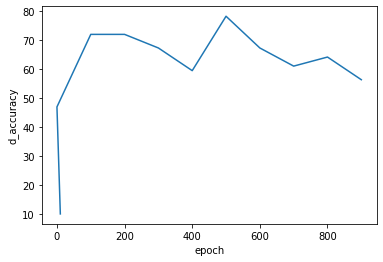

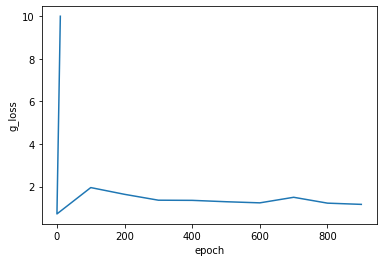

In [ ]:
# グラフを書く
plt.plot(gan.e, gan.d_acc)

# x軸のラベル
plt.xlabel("epoch")

# y軸のラベル
plt.ylabel("d_accuracy")

# 表示する
plt.show()

# グラフを書く
plt.plot(gan.e, gan.g_los)

# x軸のラベル
plt.xlabel("epoch")

# y軸のラベル
plt.ylabel("g_loss")

# 表示する
plt.show()